# GP DEFECTO Classification Model

# Model Steps:

1-Training Data
2-Preprocessing
3-Arch.
4-Fine Tune, Pre-trained mode
5-Optimize Hyperparameters, Training
6-Evalutaion
7-Deploy

## Important Libraries

In [2]:
import keras,os
from os import listdir
import cv2
import imageio
import imgaug.augmenters as iaa  
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import applications
import matplotlib.pyplot as plt

# 1- Training Data

In [2]:
train='/home/ahmed/Final GP/Casting/train'
test='/home/ahmed/Final GP/Casting/test'

# 2- Preprocessing

## Data Augmentation

In [3]:

# seq = iaa.Sequential([
#     iaa.Fliplr(0.5), # flip horizontally with 50% probability
#     iaa.Flipud(0.5), # flip vertically with 50% probability
#     iaa.Affine(rotate=(-5, 5)), # rotate images by -5 to +5 degrees
#     iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)), # add Gaussian noise with std dev between 0 and 0.1
#     iaa.GammaContrast(gamma=(0.5, 1.5)), # adjust gamma by a factor of 0.5 to 1.5
#     iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # crop images by up to 10% with 50% probability
# ])

# out generated to directory
# out_path=''


# # make sure the output directory exists
# if not os.path.exists(out_path):
#     os.makedirs(out_path)
    
# take images from this directory
# in_path=''
    
# for filename in os.listdir(in_path):
    
#     # read the image
#     img = cv2.imread(os.path.join(in_path, filename))

#     # apply the augmentation pipeline
#     augmented_images = seq(images=[img])

#     # save the augmented images to the output directory
#     for i, image in enumerate(augmented_images):
#         cv2.imwrite(os.path.join(out_path, f"{filename.split('.')[0]}_{i}.jpg"), image)

## Normalization, Scaling, Data Splitting, Size

In [4]:
#Train
trdata = ImageDataGenerator(rescale = 1/255.0,validation_split = 0.20)

traindata = trdata.flow_from_directory(directory=train ,batch_size=32 ,subset='training',
                                       target_size=(224,224), 
                                       shuffle=True,color_mode='rgb',class_mode='categorical')

#Validation
valid_generator = trdata.flow_from_directory(
    directory=train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32 ,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
)

#Test
l=listdir(test)
X_test = []
Y_test = []
for i, label in enumerate(l):
    # print(i,'  ',label)
    class_path = test + '/' + label
    for data in listdir(class_path):
        # print('** ',data)
        img = keras.utils.load_img(class_path + '/' + data,target_size=(224,224))
        img = np.asarray(img)
        img = np.expand_dims(img, axis=0)
        X_test.append(img)
        if label=='good':
            Y_test.append(1)
        else:
            Y_test.append(0)


Found 11856 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# 3- Architecture

# 4-Fine Tune, Pretrained models 

## VGG-16 

In [6]:
VGG= keras.applications.vgg16.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [7]:
VGG.trainable= False
#Not train the front 13 layers, train only last three layers

In [8]:
model_vgg = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax"),
    
])

In [9]:
model_vgg.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,203,778
Trainable params: 6,489,090
Non-trainable params: 14,714,688
_________________________________________________________________


## ResNet 50

In [11]:
RESNET = keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [12]:
RESNET.trainable= False

In [18]:
model_resnet = keras.Sequential([
    RESNET,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax"),
    
])

In [20]:
model_resnet.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [21]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49,278,594
Trainable params: 25,690,882
Non-trainable params: 23,587,712
_________________________________________________________________


# 5- Training, Optimize Hyperparameters

## vgg-16

In [16]:
hist_vgg = model_vgg.fit(traindata,steps_per_epoch=370, batch_size=32, validation_data=valid_generator, validation_steps=90, epochs=10)


Epoch 1/10


2023-06-30 18:50:05.396400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-30 18:50:06.286851: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-06-30 18:50:06.427593: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  1/370 [..............................] - ETA: 39:20 - loss: 0.8920 - accuracy: 0.3438

2023-06-30 18:50:11.811095: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-06-30 18:50:11.947698: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  2/370 [..............................] - ETA: 33:53 - loss: 3.4031 - accuracy: 0.4375

2023-06-30 18:50:17.336514: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


370/370 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8836

2023-06-30 19:26:31.554136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


370/370 [==============================] - 2715s 7s/step - loss: 0.3187 - accuracy: 0.8836 - val_loss: 0.0806 - val_accuracy: 0.9757
Epoch 2/10
370/370 [==============================] - 2722s 7s/step - loss: 0.0893 - accuracy: 0.9689 - val_loss: 0.0596 - val_accuracy: 0.9802
Epoch 3/10
370/370 [==============================] - 2706s 7s/step - loss: 0.0917 - accuracy: 0.9669 - val_loss: 0.0463 - val_accuracy: 0.9819
Epoch 4/10
370/370 [==============================] - 2685s 7s/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.0636 - val_accuracy: 0.9764
Epoch 5/10
370/370 [==============================] - 2643s 7s/step - loss: 0.0573 - accuracy: 0.9818 - val_loss: 0.1083 - val_accuracy: 0.9556
Epoch 6/10
370/370 [==============================] - 2625s 7s/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0692 - val_accuracy: 0.9750
Epoch 7/10
370/370 [==============================] - 2639s 7s/step - loss: 0.0299 - accuracy: 0.9894 - val_loss: 0.0664 - val_accuracy: 0.9792
Epo

## resnet-50

In [22]:
hist_resnet = model_resnet.fit(traindata,steps_per_epoch=370, batch_size=32, validation_data=valid_generator, validation_steps=90, epochs=10)

Epoch 1/10


2023-07-01 04:56:41.859670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


370/370 [==============================] - ETA: 0s - loss: 0.8546 - accuracy: 0.6571

2023-07-01 05:10:08.127155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


370/370 [==============================] - 986s 3s/step - loss: 0.8546 - accuracy: 0.6571 - val_loss: 0.5524 - val_accuracy: 0.6691
Epoch 2/10
370/370 [==============================] - 985s 3s/step - loss: 0.5230 - accuracy: 0.7267 - val_loss: 0.4375 - val_accuracy: 0.8083
Epoch 3/10
370/370 [==============================] - 984s 3s/step - loss: 0.4485 - accuracy: 0.7816 - val_loss: 0.4104 - val_accuracy: 0.8212
Epoch 4/10
370/370 [==============================] - 989s 3s/step - loss: 0.4032 - accuracy: 0.8102 - val_loss: 0.4628 - val_accuracy: 0.7372
Epoch 5/10
370/370 [==============================] - 987s 3s/step - loss: 0.3753 - accuracy: 0.8229 - val_loss: 0.3167 - val_accuracy: 0.8667
Epoch 6/10
370/370 [==============================] - 986s 3s/step - loss: 0.3720 - accuracy: 0.8290 - val_loss: 0.3494 - val_accuracy: 0.8219
Epoch 7/10
370/370 [==============================] - 990s 3s/step - loss: 0.3201 - accuracy: 0.8582 - val_loss: 0.3726 - val_accuracy: 0.8233
Epoch 8/10

## saving models

In [23]:
model_vgg.save('model_vgg.h5')
model_resnet.save('model_resnet.h5')

In [24]:
import pickle

with open('model_vgg.pkl', 'wb') as file:
    pickle.dump(model_vgg, file)
    
with open('model_resnet.pkl', 'wb') as file:
    pickle.dump(model_resnet, file)


In [26]:
# Step 1: Convert the model to a TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_vgg)
tflite_model = converter.convert()

# Step 2: Save the TFLite model to a file
with open('model_vgg.tflite', 'wb') as file:
    file.write(tflite_model)
    
converter = tf.lite.TFLiteConverter.from_keras_model(model_resnet)
tflite_model = converter.convert()

with open('model_resnet.tflite', 'wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpieiiuncl/assets


INFO:tensorflow:Assets written to: /tmp/tmpieiiuncl/assets
2023-07-01 13:53:16.446878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-01 13:53:16.446907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-01 13:53:16.448559: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpieiiuncl
2023-07-01 13:53:16.451494: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-01 13:53:16.451514: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpieiiuncl
2023-07-01 13:53:16.463511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-01 13:53:16.465713: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-01 13:53:16.582529: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmp4s0ta9_k/assets


INFO:tensorflow:Assets written to: /tmp/tmp4s0ta9_k/assets
2023-07-01 13:53:49.302015: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-01 13:53:49.302041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-01 13:53:49.302300: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4s0ta9_k
2023-07-01 13:53:49.328419: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-01 13:53:49.328445: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4s0ta9_k
2023-07-01 13:53:49.445657: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-01 13:53:51.438381: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp4s0ta9_k
2023-07-01 13:53:51.682174: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

# 6- Evaluation

## vgg16

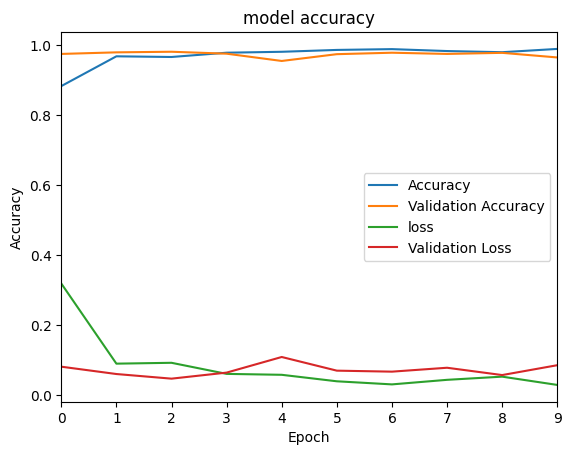

In [32]:

plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.xlim(0, 9)
plt.show()

## resnet50

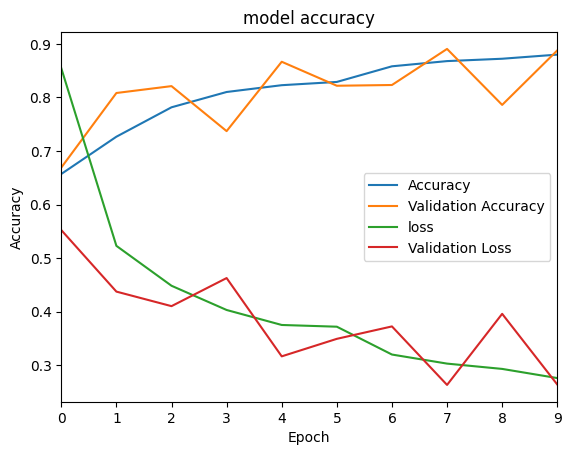

In [33]:
plt.plot(hist_resnet.history['accuracy'])
plt.plot(hist_resnet.history['val_accuracy'])
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_resnet.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.xlim(0, 9)
plt.show()

## Predictions

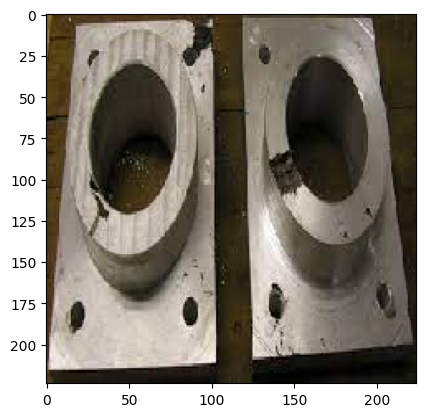

In [34]:
from keras.preprocessing import image
img = keras.utils.load_img("/home/ahmed/Final GP/check.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

### vgg

In [38]:
from keras.models import load_model
saved_model_vgg = load_model("model_vgg.h5")
output = saved_model_vgg.predict(img)
print(output[0][0])
print(output[0][1])
if output[0][0] > output[0][1]:
    print("defected")
else:
    print("good")

1/1 [==============================] - 1s 580ms/step
1.0
0.0
defected


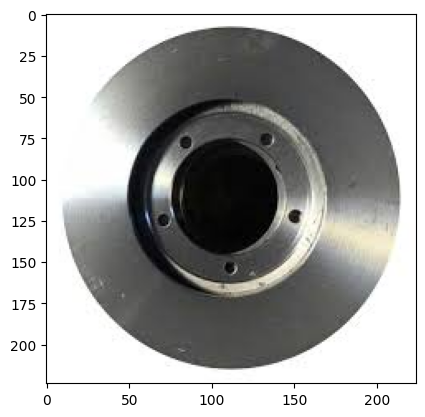

In [11]:
from keras.preprocessing import image
img = keras.utils.load_img("/home/ahmed/Downloads/test.jpeg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [14]:
from keras.models import load_model
output = saved_model_vgg.predict(img)
print(output[0][0])
print(output[0][1])
if output[0][0] > output[0][1]:
    print("defected")
else:
    print("good")

1/1 [==============================] - 0s 132ms/step
0.0
1.0
good


### resnet

In [39]:

saved_model_resnet = load_model("model_resnet.h5")
output = saved_model_resnet.predict(img)
print(output[0][0])
print(output[0][1])
if output[0][0] > output[0][1]:
    print("defected")
else:
    print("good")

1/1 [==============================] - 1s 988ms/step
1.0
9.436404e-16
defected


# Evaluation Metrics

In [40]:
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Precision= TP/(TP + FP) = Accuracy of positive predictions.

### Recall = TP/(TP+FN) = Fraction of positives that were correctly identified.

### F1 Score = 2*(Recall * Precision) / (Recall + Precision) = What percent of positive predictions were correct? 

## vgg

In [41]:
Y_pred=[]

for i in range(len(X_test)):
    pred = saved_model_vgg.predict(X_test[i])
    #defected
    if pred[0][0] > pred[0][1]:
        Y_pred.append(0)
    #good
    else:
        Y_pred.append(1)


1/1 [==============================] - 0s 174ms/step
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       453
           1       0.82      0.98      0.90       524

    accuracy                           0.88       977
   macro avg       0.90      0.87      0.87       977
weighted avg       0.89      0.88      0.87       977

[[342 111]
 [  9 515]]


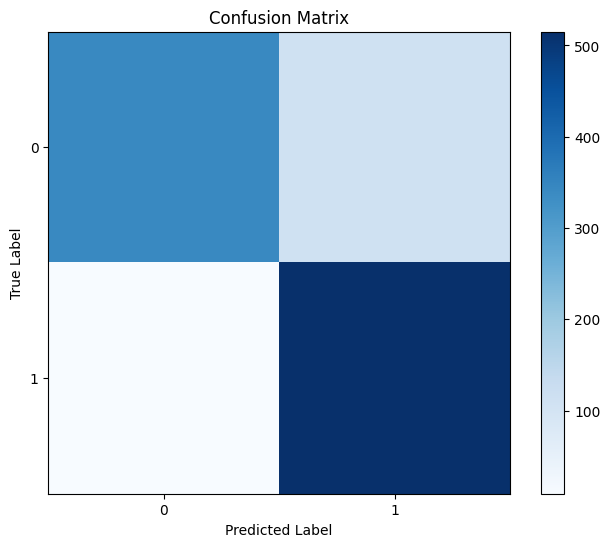

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       453
           1       0.82      0.98      0.90       524

    accuracy                           0.88       977
   macro avg       0.90      0.87      0.87       977
weighted avg       0.89      0.88      0.87       977



In [43]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(Y_test)))
plt.xticks(tick_marks, np.unique(Y_test))
plt.yticks(tick_marks, np.unique(Y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate the classification report
report = classification_report(Y_test, Y_pred)

print('Classification Report:')
print(report)

# 7- Deploy

## Make predictions with real-time stream in the DEFECTO System 